<a href="https://colab.research.google.com/github/AbeRodz/Machine-learning/blob/analisis_inicial/Analisis_inicial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
pip install geopandas pyshp contextily

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
cd drive/MyDrive/dataset/

/content/drive/MyDrive/dataset


In [7]:
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import matplotlib.pyplot as plt
import contextily as ctx
import matplotlib.colors as colors
import shapefile as shp
import seaborn as sns
import numpy as np
import geopandas as gpd

In [8]:
geo_map = gpd.read_file("./shapefiles/taxi_zones.shp")

<Axes: >

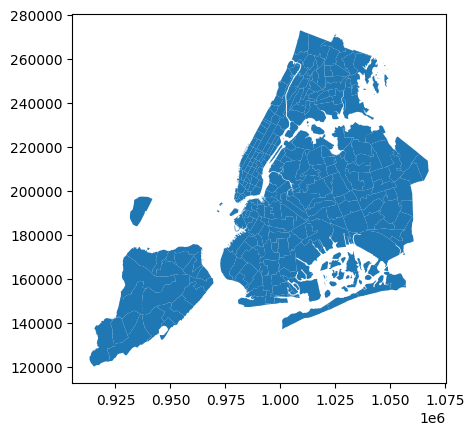

In [9]:
geo_map.plot()

## UTILITY FUNCTIONS

In [10]:
def open_sample_from_file(path : str,column_to_search: str = None , search_value:str = None, show_columns = False) -> pd.DataFrame:
    """
    Helper function to read a file sample with optional search conditions
    """
    parquet = path.endswith('parquet')
    func = getattr(pd, f'read_csv')
    if parquet:
        engine = 'auto'
        func = getattr(pd, f'read_parquet')
        return func(path, engine)
    
    if column_to_search:
        if search_value != None:
            df = func(path)
            return df[df[column_to_search] == search_value]
        
        return func(path)[column_to_search] 

    if show_columns:
        return func(path).columns

    return func(path)

In [11]:
def open_season(path: str = "./dataset/",season: str = "winter", drop_values = True) -> pd.DataFrame:
    """
    Helper function to open and separate the dataset on seasons.

    winter  01-01 -> - 02-28 (59 days of the year)
    spring  03-01 -> 05-31
    summer 06-01 -> 08-31
    autumn 09-01 -> 11-31
    """
    seasons = {"winter":[path + "yellow_tripdata_2022-01.parquet",path + "yellow_tripdata_2022-02.parquet"
                          ],
               "spring":[path +"yellow_tripdata_2022-03.parquet",path +"yellow_tripdata_2022-04.parquet",path + "yellow_tripdata_2022-05.parquet"
                          ],
               "summer":[path + "yellow_tripdata_2022-06.parquet",path +"yellow_tripdata_2022-07.parquet",path + "yellow_tripdata_2022-08.parquet"
                          ],
               "autumn" :[path + "yellow_tripdata_2022-09.parquet",path +"yellow_tripdata_2022-10.parquet",path + "yellow_tripdata_2022-11.parquet"
                          ]
               }
    if season in seasons:
  
      df  = pd.concat(
      map(pd.read_parquet, seasons.get(season)), ignore_index=True)
      if drop_values:
        df = df.drop(['VendorID','store_and_fwd_flag', 'extra', 'mta_tax', 'improvement_surcharge', 'congestion_surcharge'], axis=1)
      return df
    return False

In [105]:
def calculate_maxes(df: pd.DataFrame, col_name:str):
    total_amount_min = df[col_name].min()
    total_amount_max = df[col_name].max()
    return (total_amount_max,total_amount_min)

In [12]:
df = open_season(path = "",season= "winter")

In [110]:
df.columns

Index(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count',
       'trip_distance', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'payment_type', 'fare_amount', 'tip_amount', 'tolls_amount',
       'total_amount', 'airport_fee', 'date', 'time', 'weekday', 'duration',
       'day_of_year', 'day_week', 'day_type', 'trips_number'],
      dtype='object')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5443362 entries, 0 to 5443361
Data columns (total 13 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   tpep_pickup_datetime   datetime64[ns]
 1   tpep_dropoff_datetime  datetime64[ns]
 2   passenger_count        float64       
 3   trip_distance          float64       
 4   RatecodeID             float64       
 5   PULocationID           int64         
 6   DOLocationID           int64         
 7   payment_type           int64         
 8   fare_amount            float64       
 9   tip_amount             float64       
 10  tolls_amount           float64       
 11  total_amount           float64       
 12  airport_fee            float64       
dtypes: datetime64[ns](2), float64(8), int64(3)
memory usage: 539.9 MB


## 2. Análisis exploratorio inicial

### Visualizar las primeras filas.

In [88]:
taxi_zones = open_sample_from_file("./taxi+_zone_lookup.csv")

In [103]:
taxi_zones

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone
...,...,...,...,...
260,261,Manhattan,World Trade Center,Yellow Zone
261,262,Manhattan,Yorkville East,Yellow Zone
262,263,Manhattan,Yorkville West,Yellow Zone
263,264,Unknown,NV,NaN


In [104]:
taxi_zones[taxi_zones["Borough"] != 'Manhattan']

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
4,5,Staten Island,Arden Heights,Boro Zone
5,6,Staten Island,Arrochar/Fort Wadsworth,Boro Zone
...,...,...,...,...
257,258,Queens,Woodhaven,Boro Zone
258,259,Bronx,Woodlawn/Wakefield,Boro Zone
259,260,Queens,Woodside,Boro Zone
263,264,Unknown,NV,NaN


In [96]:
taxi_zones_ids= taxi_zones[taxi_zones['service_zone']=='Yellow Zone'].LocationID.values

In [15]:
df.head(5)

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,tolls_amount,total_amount,airport_fee
0,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,142,236,1,14.5,3.65,0.0,21.95,0.0
1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,236,42,1,8.0,4.00,0.0,13.30,0.0
2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,166,166,1,7.5,1.76,0.0,10.56,0.0
3,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,114,68,2,8.0,0.00,0.0,11.80,0.0
4,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,68,163,1,23.5,3.00,0.0,30.30,0.0


## Realizar un resumen de 5 números.

In [16]:
df.describe()

,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,tolls_amount,total_amount,airport_fee
count,5.270121e+06,5.443362e+06,5.270121e+06,5.443362e+06,5.443362e+06,5.443362e+06,5.443362e+06,5.443362e+06,5.443362e+06,5.443362e+06,5.270121e+06
mean,1.390917e+00,5.635142e+00,1.419827e+00,1.657783e+02,1.635005e+02,1.183061e+00,1.304498e+01,2.448713e+00,3.793579e-01,1.934911e+01,7.766212e-02
std,9.836000e-01,6.015312e+02,5.972370e+00,6.554616e+01,7.058795e+01,4.975932e-01,1.723407e+02,2.808154e+00,1.675431e+00,1.725652e+02,3.038566e-01
min,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,-6.000000e+02,-1.880000e+02,-3.140000e+01,-6.003000e+02,-1.250000e+00
25%,1.000000e+00,1.060000e+00,1.000000e+00,1.320000e+02,1.130000e+02,1.000000e+00,6.500000e+00,1.000000e+00,0.000000e+00,1.175000e+01,0.000000e+00
50%,1.000000e+00,1.770000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,9.500000e+00,2.050000e+00,0.000000e+00,1.476000e+01,0.000000e+00
75%,1.000000e+00,3.170000e+00,1.000000e+00,2.340000e+02,2.340000e+02,1.000000e+00,1.400000e+01,3.060000e+00,0.000000e+00,2.047000e+01,0.000000e+00
max,9.000000e+00,3.487985e+05,9.900000e+01,2.650000e+02,2.650000e+02,5.000000e+00,4.010923e+05,8.888800e+02,1.933000e+02,4.010956e+05,1.250000e+00


### Identificar los tipos de datos: categórico, ordinal, etc. Responder para cada variable su tipo y si es informativa para un problema de clasificación (por ejemplo si se trata de un código, como una matrícula, o un nombre propio).

In [17]:
df.dtypes

tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
tip_amount                      float64
tolls_amount                    float64
total_amount                    float64
airport_fee                     float64
dtype: object

In [18]:
df['passenger_count'].value_counts()

1.0    3944723
2.0     763326
3.0     188228
0.0     114266
5.0     110394
4.0      76448
6.0      72700
8.0         18
7.0         12
9.0          6
Name: passenger_count, dtype: int64

In [19]:
df['payment_type'].value_counts()

1    4171093
2    1051277
0     173241
3      24821
4      22928
5          2
Name: payment_type, dtype: int64

In [20]:
df['RatecodeID'].value_counts()

1.0     5063607
2.0      143888
5.0       27662
99.0      19599
3.0        8884
4.0        6435
6.0          46
Name: RatecodeID, dtype: int64

| Nombre campo | Tipo de dato | Tipo | Significado
|-----------|-----------|-----------|-----------|
|VendorID              | int64      | Categórica | Empresa telefonía
|tpep_pickup_datetime  | datetime64 |Fecha/hora | Inicio viaje
|tpep_dropoff_datetime | datetime64 | Fecha/hora | Fin viaje
|passenger_count       | float64    |Numerica | Cantidad pasajeros
|trip_distance         | float64    |Numerica  | Distancia viaje
|RatecodeID            | float64    | Categórica | Codigo tarifa
|store_and_fwd_flag    | object     | Categórica | Se guardo en memoria 
|PULocationID          | int64      |Categórica | Id zona comienzo
|DOLocationID          | int64      |Categórica | Id zona fin
|payment_type          | int64      | Categórica | Forma de pago
|fare_amount           | float64    |Numerica | Monto del viaje
|extra                 | float64    |Numerica | Extras
|mta_tax               | float64    |Numerica | Impuesto MTA
|tip_amount            | float64    |Numerica | Propina
|tolls_amount          | float64    |Numerica | Monto peajes
|improvement_surcharge | float64    |Numerica | Recargo por mejoras
|total_amount          | float64    | Numerica| Monto total
|congestion_surcharge  | float64    | Numerica | Recargo por congestión
|airport_fee           | float64    |Numerica | Tarifa aeropuerto           |

### Identificar las variables de entrada y de salida del problema. 

### Variables de Entrada

| Nombre campo | Tipo de dato | Tipo | Significado
|-----------|-----------|-----------|-----------|
|tpep_pickup_datetime  | datetime64 |Fecha/hora | Inicio viaje
|tpep_dropoff_datetime | datetime64 | Fecha/hora | Fin viaje
|passenger_count       | float64    |Numerica | Cantidad pasajeros
|trip_distance         | float64    |Numerica  | Distancia viaje
|PULocationID          | int64      |Categórica | Id zona comienzo
|DOLocationID          | int64      |Categórica | Id zona fin
|payment_type          | int64      | Categórica | Forma de pago
|fare_amount           | float64    |Numerica | Monto del viaje calculado por el taximetro
|tip_amount            | float64    |Numerica | Propina
|tolls_amount          | float64    |Numerica | Monto peajes
|airport_fee           | float64    |Numerica | Tarifa aeropuerto           |



### Analisis por tipo de variable

### Numericas (distribucion de los datos)

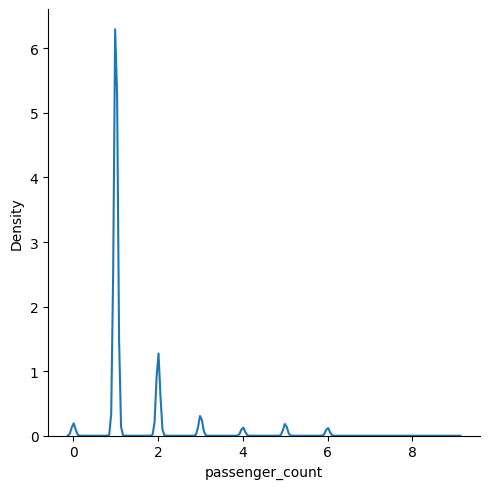

In [21]:
sns.displot(df.passenger_count, kind= 'kde')

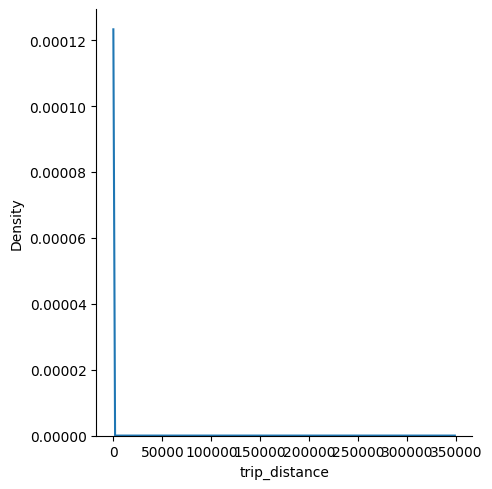

In [22]:
sns.displot(df.trip_distance, kind= 'kde')

In [23]:
def display_dataset_distributions(dataset):
    fig = dataset.hist(xlabelsize=8, ylabelsize=8,figsize=(18,10))
    [x.title.set_size(14) for x in fig.ravel()]
    plt.tight_layout()
    plt.show()

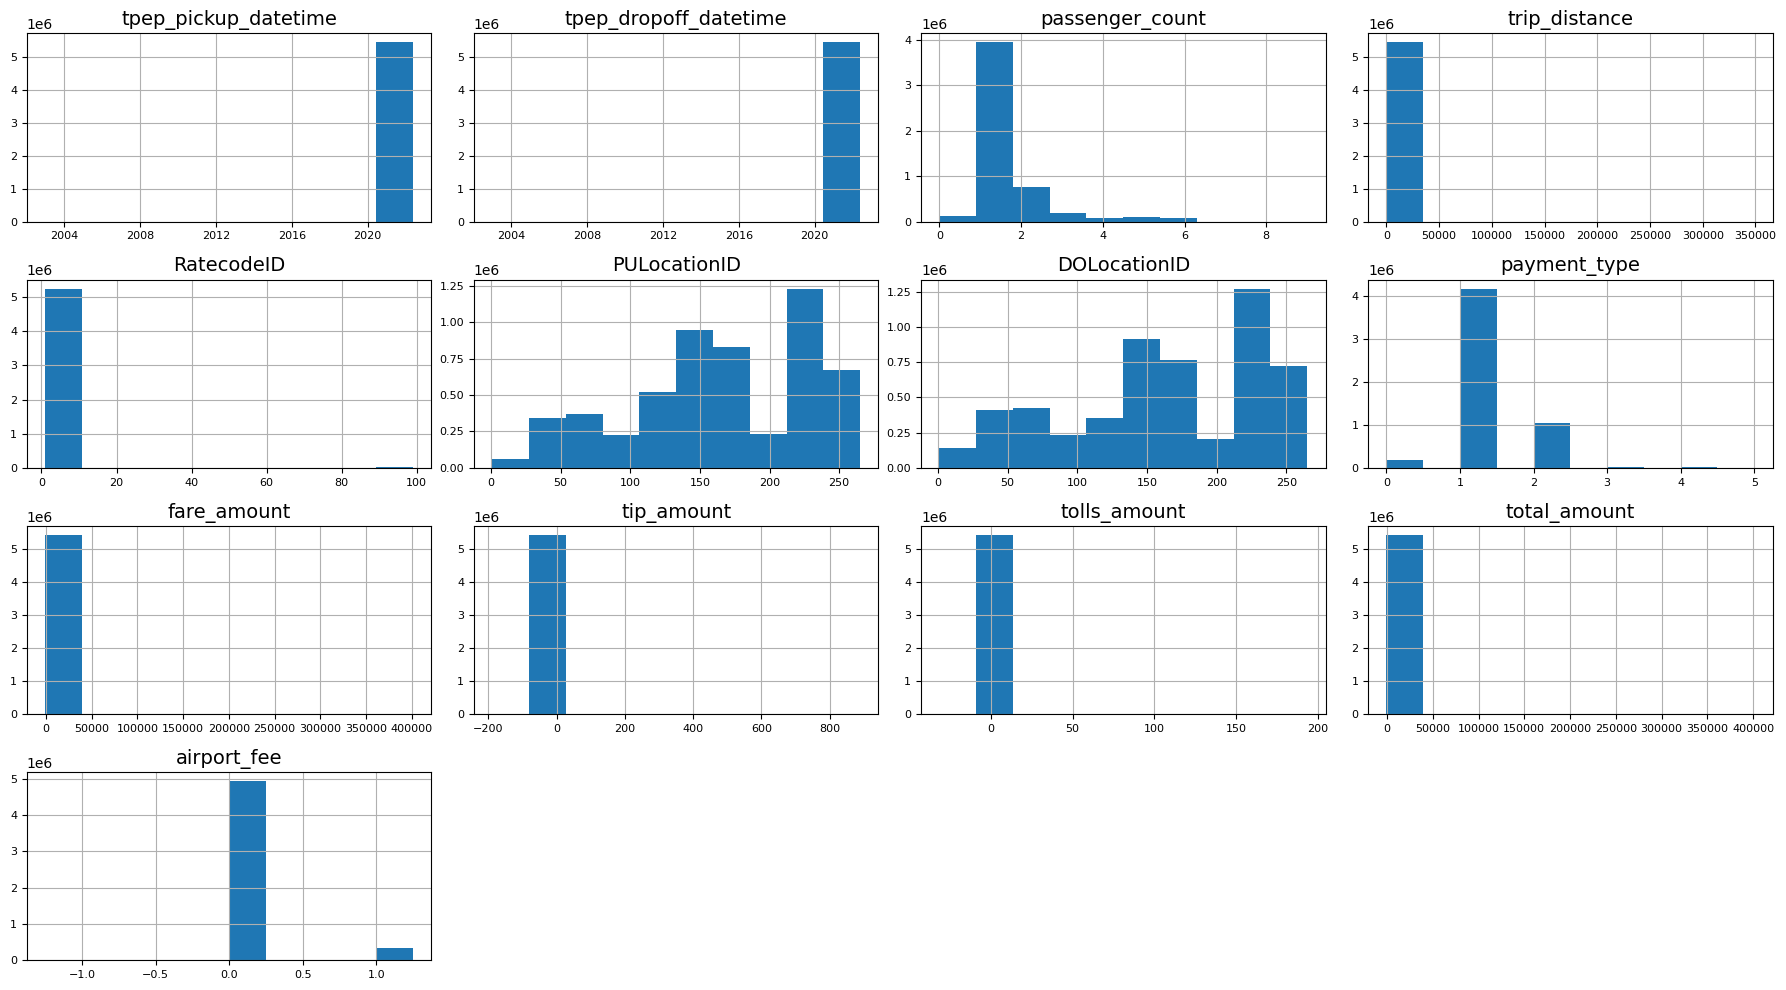

In [24]:
display_dataset_distributions(df)

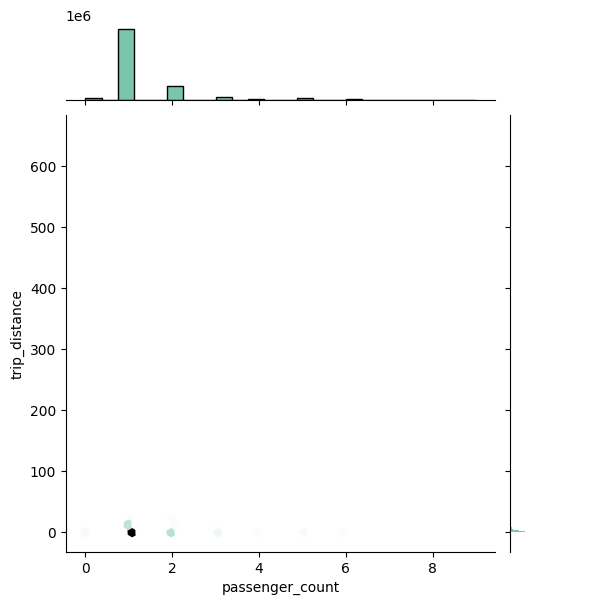

In [25]:
sns.jointplot(x=df.passenger_count, y=df.trip_distance, kind="hex", color="#4CB391")

In [26]:
df.total_amount.median()

14.76

In [27]:
df.total_amount.mode()

0    10.8
Name: total_amount, dtype: float64

In [28]:
df.total_amount.mean()

19.349111609700067

### Veamos total_amount cerca de la media

In [29]:
df.total_amount.value_counts()

10.80     89436
10.30     89006
11.30     87734
9.80      85865
11.80     85636
          ...  
108.82        1
74.38         1
77.53         1
72.76         1
76.41         1
Name: total_amount, Length: 13441, dtype: int64

In [30]:
df[(df.total_amount<0)]

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,tolls_amount,total_amount,airport_fee
154,2022-01-01 00:26:37,2022-01-01 00:39:35,1.0,7.38,1.0,132,265,4,-21.00,0.00,0.0,-23.55,-1.25
521,2022-01-01 00:27:18,2022-01-01 00:40:50,1.0,5.14,1.0,152,48,4,-17.00,0.00,0.0,-20.80,0.00
523,2022-01-01 00:59:33,2022-01-01 01:14:09,4.0,5.37,5.0,50,265,2,-75.00,0.00,0.0,-77.80,0.00
580,2022-01-01 00:16:58,2022-01-01 00:19:41,1.0,0.46,1.0,90,234,2,-4.00,0.00,0.0,-7.80,0.00
714,2022-01-01 00:29:12,2022-01-01 00:40:29,1.0,3.13,1.0,13,246,4,-12.00,0.00,0.0,-15.80,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5433236,2022-02-26 04:23:51,2022-02-26 04:26:37,NaN,0.10,NaN,255,255,0,-13.37,0.00,0.0,-12.57,NaN
5434829,2022-02-26 16:22:44,2022-02-26 16:23:56,NaN,0.02,NaN,230,230,0,-95.79,15.07,0.0,-77.42,NaN
5435416,2022-02-26 19:31:00,2022-02-26 19:32:00,NaN,0.00,NaN,246,246,0,-31.27,4.41,0.0,-23.56,NaN
5436871,2022-02-27 00:01:12,2022-02-27 00:02:58,NaN,0.02,NaN,114,114,0,-28.37,0.00,0.0,-25.07,NaN


In [31]:
df[(df.total_amount>100)]

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,tolls_amount,total_amount,airport_fee
370,2022-01-01 00:38:48,2022-01-01 00:39:01,1.0,0.00,5.0,142,142,1,150.00,0.00,0.00,152.80,0.00
799,2022-01-01 00:35:56,2022-01-01 00:36:12,1.0,0.00,5.0,79,79,1,240.00,40.00,0.00,282.80,0.00
1114,2022-01-01 00:57:40,2022-01-01 01:19:49,1.0,11.30,5.0,239,265,1,80.00,40.00,0.00,120.30,0.00
1404,2022-01-01 00:32:59,2022-01-01 01:05:34,1.0,27.85,4.0,132,265,1,124.50,25.16,0.00,152.21,1.25
1451,2022-01-01 00:32:38,2022-01-01 01:10:42,1.0,16.99,5.0,48,265,1,100.00,10.00,11.75,124.55,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5439758,2022-02-27 18:10:00,2022-02-27 18:58:00,NaN,24.61,NaN,230,265,0,90.04,22.95,20.25,136.54,NaN
5439809,2022-02-27 18:26:10,2022-02-27 19:17:38,NaN,13.68,NaN,40,132,0,80.45,19.29,0.00,100.54,NaN
5441239,2022-02-28 08:13:37,2022-02-28 08:46:47,NaN,17.18,NaN,142,1,0,68.42,16.25,13.75,101.72,NaN
5442318,2022-02-28 16:26:56,2022-02-28 17:14:56,NaN,17.89,NaN,161,1,0,67.28,17.79,18.75,107.12,NaN


In [32]:
df[df.total_amount<0]

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,tolls_amount,total_amount,airport_fee
154,2022-01-01 00:26:37,2022-01-01 00:39:35,1.0,7.38,1.0,132,265,4,-21.00,0.00,0.0,-23.55,-1.25
521,2022-01-01 00:27:18,2022-01-01 00:40:50,1.0,5.14,1.0,152,48,4,-17.00,0.00,0.0,-20.80,0.00
523,2022-01-01 00:59:33,2022-01-01 01:14:09,4.0,5.37,5.0,50,265,2,-75.00,0.00,0.0,-77.80,0.00
580,2022-01-01 00:16:58,2022-01-01 00:19:41,1.0,0.46,1.0,90,234,2,-4.00,0.00,0.0,-7.80,0.00
714,2022-01-01 00:29:12,2022-01-01 00:40:29,1.0,3.13,1.0,13,246,4,-12.00,0.00,0.0,-15.80,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5433236,2022-02-26 04:23:51,2022-02-26 04:26:37,NaN,0.10,NaN,255,255,0,-13.37,0.00,0.0,-12.57,NaN
5434829,2022-02-26 16:22:44,2022-02-26 16:23:56,NaN,0.02,NaN,230,230,0,-95.79,15.07,0.0,-77.42,NaN
5435416,2022-02-26 19:31:00,2022-02-26 19:32:00,NaN,0.00,NaN,246,246,0,-31.27,4.41,0.0,-23.56,NaN
5436871,2022-02-27 00:01:12,2022-02-27 00:02:58,NaN,0.02,NaN,114,114,0,-28.37,0.00,0.0,-25.07,NaN


In [33]:
def plot_distribution_with_info(df:pd.DataFrame,col_name = None, show_info = True,ax = None, filter = None):
  if col_name is None:
    return
    
  df = df[(df[col_name]<=100) & (df[col_name]>=0)][col_name]

  if filter is not None:
    df = filter

  sns.displot( df, kind = 'kde',ax= ax)
  if show_info:
    plt.axvline(x=df.mean(),
                color='red')
    plt.axvline(x=df.median(),
                color='blue',
                ls='--', 
                lw=2.5)

In [34]:
def plot_all(df):
    fig = plot_distribution_with_info(df)
    [x.title.set_size(14) for x in fig.ravel()]
    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2142: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try kdeplot.
  warnings.warn(msg, UserWarning)


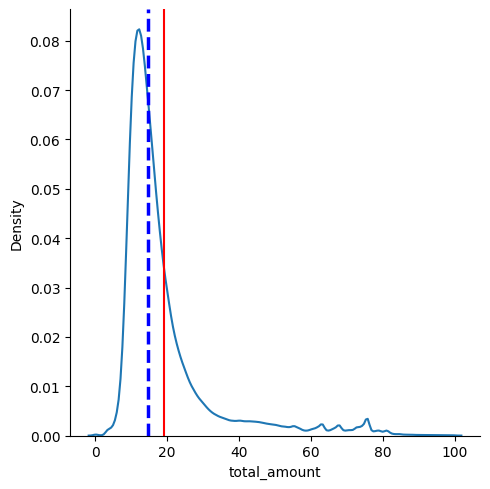

In [35]:
plot_distribution_with_info(df,"total_amount")

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2142: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try kdeplot.
  warnings.warn(msg, UserWarning)


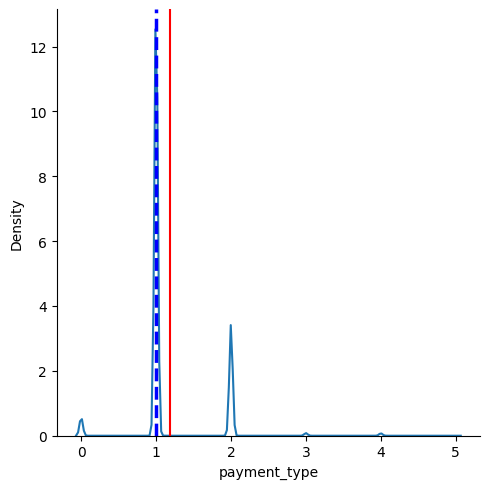

In [36]:
plot_distribution_with_info(df,"payment_type")

In [37]:
trip_filter = df[(df["trip_distance"]<=50)]["trip_distance"]

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2142: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try kdeplot.
  warnings.warn(msg, UserWarning)


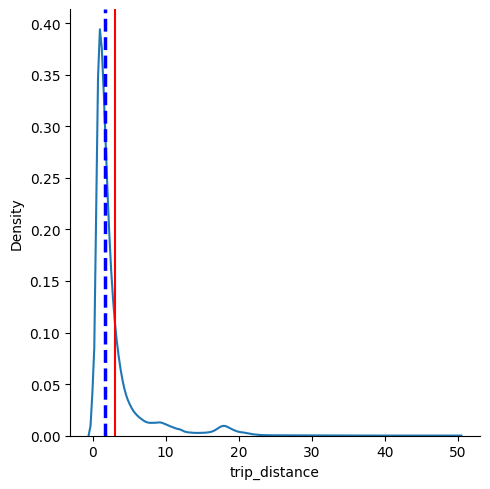

In [38]:
plot_distribution_with_info(df,"trip_distance", filter = trip_filter )

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2142: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try kdeplot.
  warnings.warn(msg, UserWarning)


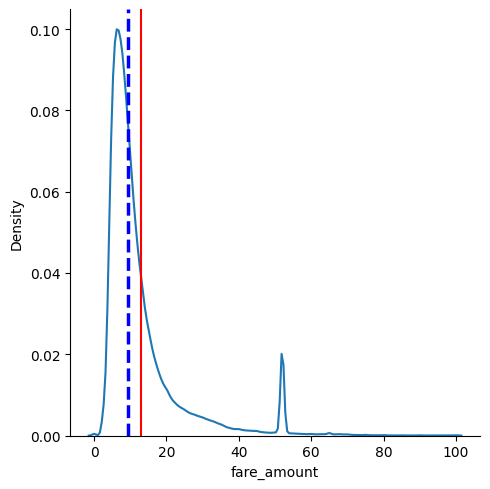

In [39]:
plot_distribution_with_info(df,"fare_amount")

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2142: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try kdeplot.
  warnings.warn(msg, UserWarning)


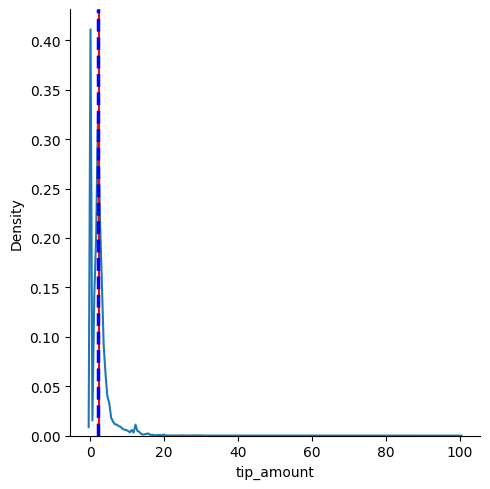

In [40]:
plot_distribution_with_info(df,"tip_amount")

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2142: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try kdeplot.
  warnings.warn(msg, UserWarning)


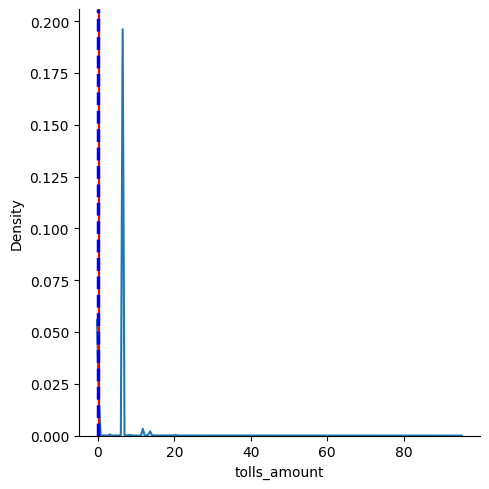

In [41]:
plot_distribution_with_info(df,"tolls_amount")

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2142: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try kdeplot.
  warnings.warn(msg, UserWarning)


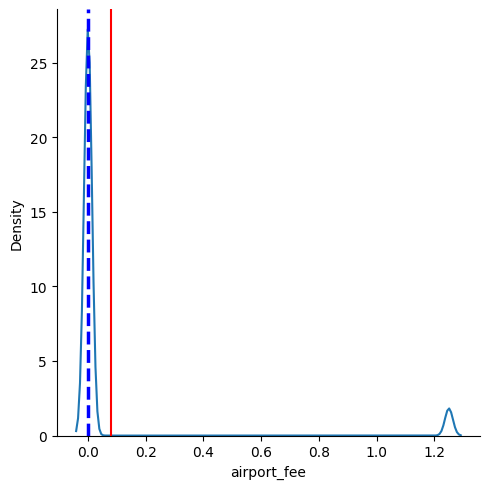

In [42]:
plot_distribution_with_info(df,"airport_fee")

### De las variables tpep_pickup_datetime tpep_dropoff_datetime  se puede obtener mas data, al distribuirla por hora, fecha, duracion de la trayectoria

In [43]:
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
df['date'] = df['tpep_pickup_datetime'].dt.normalize()
df['time'] = df['tpep_pickup_datetime'].dt.hour
df['weekday'] = df['date'].dt.day_name()
df['duration'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']
df['duration'] = df['duration'] / np.timedelta64(1, 'm')

In [44]:
df['day_of_year'] =pd.to_datetime(df['tpep_dropoff_datetime']).dt.strftime('%m-%d')

In [45]:
df['day_of_year'].value_counts()

02-26    122951
02-24    119793
02-12    119709
02-25    117706
02-11    117169
          ...  
03-12         1
03-09         1
03-17         1
05-24         1
04-09         1
Name: day_of_year, Length: 78, dtype: int64

In [46]:
cal = calendar()
holidays = cal.holidays(start='2022-01-01', end='2022-12-31')
df['holiday'] = df['date'].isin(holidays)
df['day_week'] = df['date'].dt.dayofweek
df.loc[df['day_week'] >= 5, 'day_type'] = "weekend"
df.loc[df['day_week'] < 5, 'day_type'] = "workday"
df.loc[df['holiday'] == True, 'day_type'] = "holiday"
df = df.drop(['holiday'], axis=1)

In [47]:
df

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,tolls_amount,total_amount,airport_fee,date,time,weekday,duration,day_of_year,day_week,day_type
0,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,142,236,1,14.50,3.65,0.0,21.95,0.0,2022-01-01,0,Saturday,17.816667,01-01,5,weekend
1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,236,42,1,8.00,4.00,0.0,13.30,0.0,2022-01-01,0,Saturday,8.400000,01-01,5,weekend
2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,166,166,1,7.50,1.76,0.0,10.56,0.0,2022-01-01,0,Saturday,8.966667,01-01,5,weekend
3,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,114,68,2,8.00,0.00,0.0,11.80,0.0,2022-01-01,0,Saturday,10.033333,01-01,5,weekend
4,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,68,163,1,23.50,3.00,0.0,30.30,0.0,2022-01-01,0,Saturday,37.533333,01-01,5,weekend
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5443357,2022-02-28 23:50:00,2022-03-01 00:06:00,NaN,3.40,NaN,163,193,0,14.37,0.00,0.0,17.67,NaN,2022-02-28,23,Monday,16.000000,03-01,0,workday
5443358,2022-02-28 23:06:57,2022-02-28 23:19:12,NaN,3.48,NaN,141,4,0,14.51,2.00,0.0,19.81,NaN,2022-02-28,23,Monday,12.250000,02-28,0,workday
5443359,2022-02-28 23:48:13,2022-03-01 00:03:33,NaN,3.05,NaN,161,151,0,14.38,3.81,0.0,21.49,NaN,2022-02-28,23,Monday,15.333333,03-01,0,workday
5443360,2022-02-28 23:56:41,2022-03-01 00:04:57,NaN,2.62,NaN,141,226,0,12.53,1.71,0.0,17.54,NaN,2022-02-28,23,Monday,8.266667,03-01,0,workday


In [48]:
df['weekday']

0          Saturday
1          Saturday
2          Saturday
3          Saturday
4          Saturday
             ...   
5443357      Monday
5443358      Monday
5443359      Monday
5443360      Monday
5443361      Monday
Name: weekday, Length: 5443362, dtype: object

In [49]:
df['date']

0         2022-01-01
1         2022-01-01
2         2022-01-01
3         2022-01-01
4         2022-01-01
             ...    
5443357   2022-02-28
5443358   2022-02-28
5443359   2022-02-28
5443360   2022-02-28
5443361   2022-02-28
Name: date, Length: 5443362, dtype: datetime64[ns]

In [50]:
df['day_week']

0          5
1          5
2          5
3          5
4          5
          ..
5443357    0
5443358    0
5443359    0
5443360    0
5443361    0
Name: day_week, Length: 5443362, dtype: int64

<Axes: xlabel='day_week', ylabel='Count'>

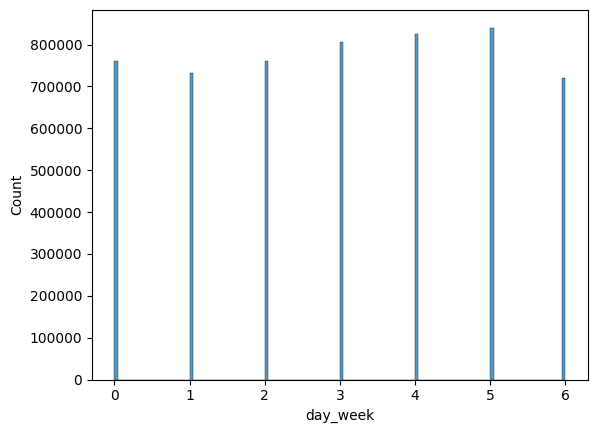

In [51]:
sns.histplot(df["day_week"])

In [52]:
df['day_week'].unique()

array([5, 4, 6, 2, 0, 1, 3])

In [53]:
friday = df[df['day_week']==0]

In [54]:
trip_filter_friday = friday[(friday["trip_distance"]<=50)]["trip_distance"]

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2142: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try kdeplot.
  warnings.warn(msg, UserWarning)


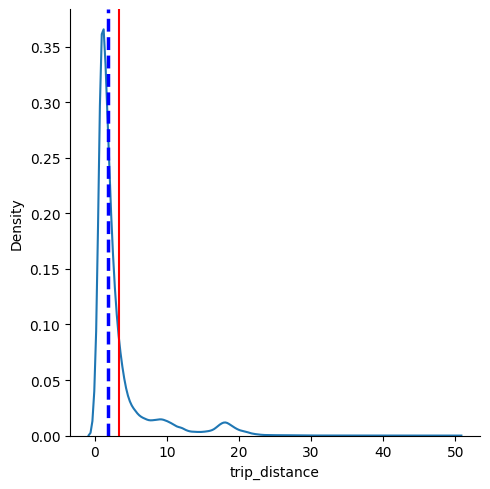

In [55]:
plot_distribution_with_info(friday,"trip_distance", filter = trip_filter_friday)

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2142: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try kdeplot.
  warnings.warn(msg, UserWarning)


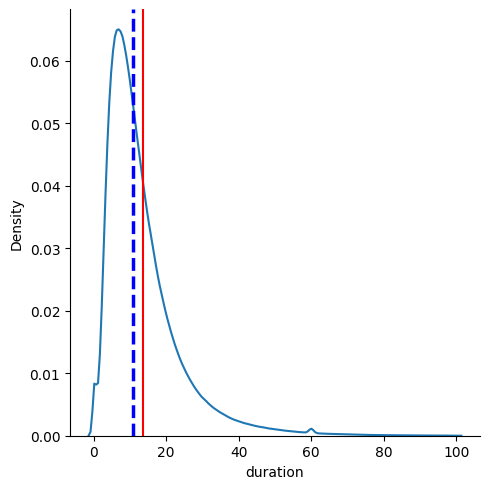

In [56]:
plot_distribution_with_info(df,"duration")

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2142: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try kdeplot.
  warnings.warn(msg, UserWarning)


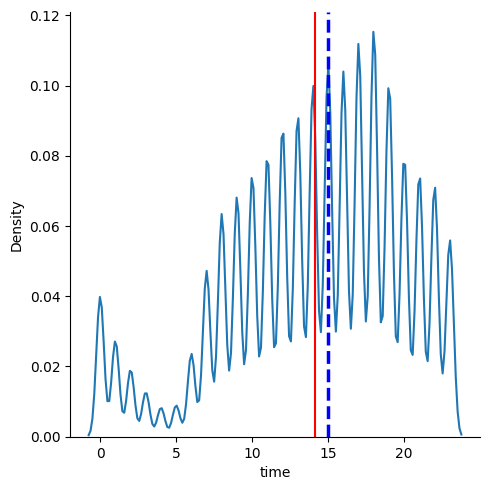

In [57]:
plot_distribution_with_info(df,"time")

<Axes: >

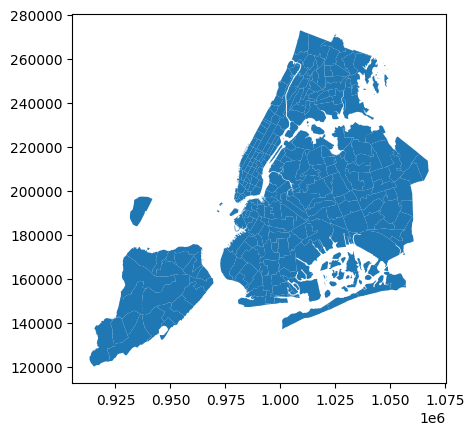

In [58]:
geo_map.plot()

In [59]:
pu_zone = df.groupby(['PULocationID'], as_index=False).size()
do_zone = df.groupby(['DOLocationID'], as_index=False).size()
pu_zone = gpd.GeoDataFrame(pd.merge(pu_zone, geo_map, left_on='PULocationID', right_on='LocationID')).drop('LocationID', axis=1)
do_zone = gpd.GeoDataFrame(pd.merge(do_zone, geo_map, left_on='DOLocationID', right_on='LocationID')).drop('LocationID', axis=1)

In [60]:
df.groupby(['PULocationID'], as_index=False).size()

,PULocationID,size
0,1,702
1,2,5
2,3,73
3,4,6786
4,5,71
...,...,...
255,261,20044
256,262,81561
257,263,130784
258,264,50221


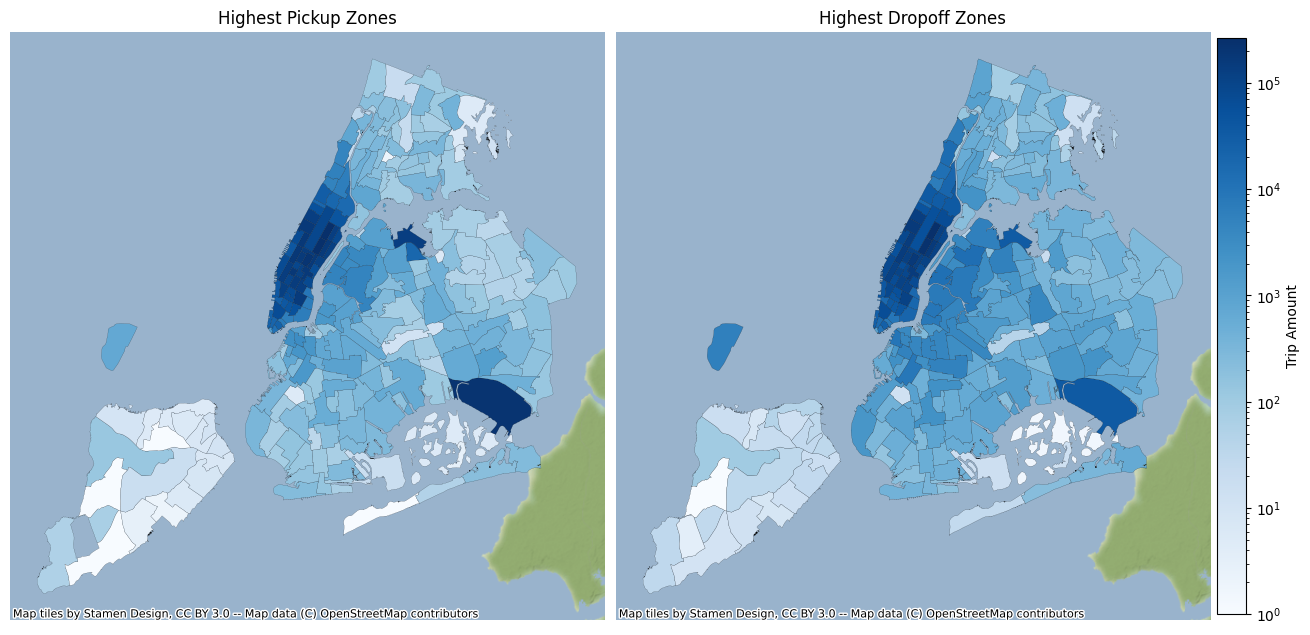

In [118]:
fig, axs = plt.subplots(ncols=2, figsize=(20, 10))
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.09, right=0.8, wspace=0.02, hspace=0.02)
# create a normalized colorbar
vmin, vmax = pu_zone['size'].min(), pu_zone['size'].max()
axs[0] = pu_zone.plot(column='size', linewidth=0.09, edgecolor='k', figsize=(10, 10), 
    norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='Blues', legend=False, ax=axs[0]) 
ctx.add_basemap(axs[0])
vmin, vmax = do_zone['size'].min(), do_zone['size'].max()
axs[1] = do_zone.plot(column='size', linewidth=0.1, edgecolor='k', figsize=(10, 10), 
    norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='Blues', legend=False, ax=axs[1])
ctx.add_basemap(axs[1])
axs[0].set_title('Highest Pickup Zones')
axs[1].set_title('Highest Dropoff Zones')
axs[0].set_axis_off()
axs[1].set_axis_off()
# draw the color bar
patch_col = axs[0].collections[0]
cb = fig.colorbar(patch_col, ax=axs, shrink=0.72, orientation="vertical", pad=0.005)
cb.ax.set_ylabel('Trip Amount')
plt.show()

In [62]:
df.columns

Index(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count',
       'trip_distance', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'payment_type', 'fare_amount', 'tip_amount', 'tolls_amount',
       'total_amount', 'airport_fee', 'date', 'time', 'weekday', 'duration',
       'day_of_year', 'day_week', 'day_type'],
      dtype='object')

In [63]:
df = df[df['date'].dt.year==2022]
df = df[df['date'].dt.dayofyear <= 58]

In [64]:
df['trips_number'] = 1
taxi_agg = df.groupby(['day_of_year', 'PULocationID'], as_index=False).agg({'trips_number':'count'})

<ipython-input-64-4f1e78fa4e5a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trips_number'] = 1


In [65]:
taxi_agg

,day_of_year,PULocationID,trips_number
0,01-01,1,43
1,01-01,3,2
2,01-01,4,121
3,01-01,5,1
4,01-01,7,82
...,...,...,...
12443,02-28,262,1
12444,02-28,263,4
12445,02-28,264,23
12446,02-28,265,4


In [66]:
(taxi_agg['trips_number']==0).sum()

0

In [67]:
taxi_agg['PULocationID'].nunique()

260

In [68]:
df['date'].dt.year.value_counts()

2022    5341053
Name: date, dtype: int64

In [69]:
df[df['date'].dt.dayofyear <= 59]['date'].value_counts().index.max()

Timestamp('2022-02-27 00:00:00')

In [70]:
df_trips = pd.DataFrame(taxi_agg).set_index('day_of_year')

In [71]:
df_trips

,PULocationID,trips_number
day_of_year,,
01-01,1,43
01-01,3,2
01-01,4,121
01-01,5,1
01-01,7,82
...,...,...
02-28,262,1
02-28,263,4
02-28,264,23


<Axes: xlabel='day_of_year'>

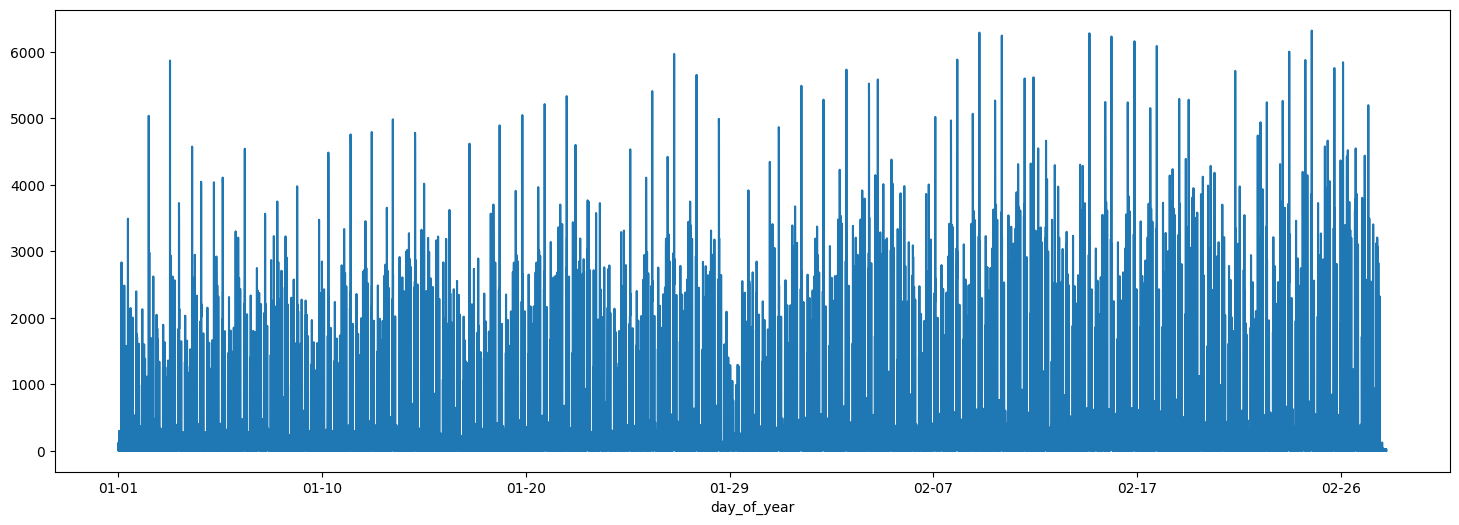

In [72]:
df_trips['trips_number'].plot(figsize=(18,6))


<ipython-input-73-be8e7d4a6e7c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr(method = 'spearman').round(2)


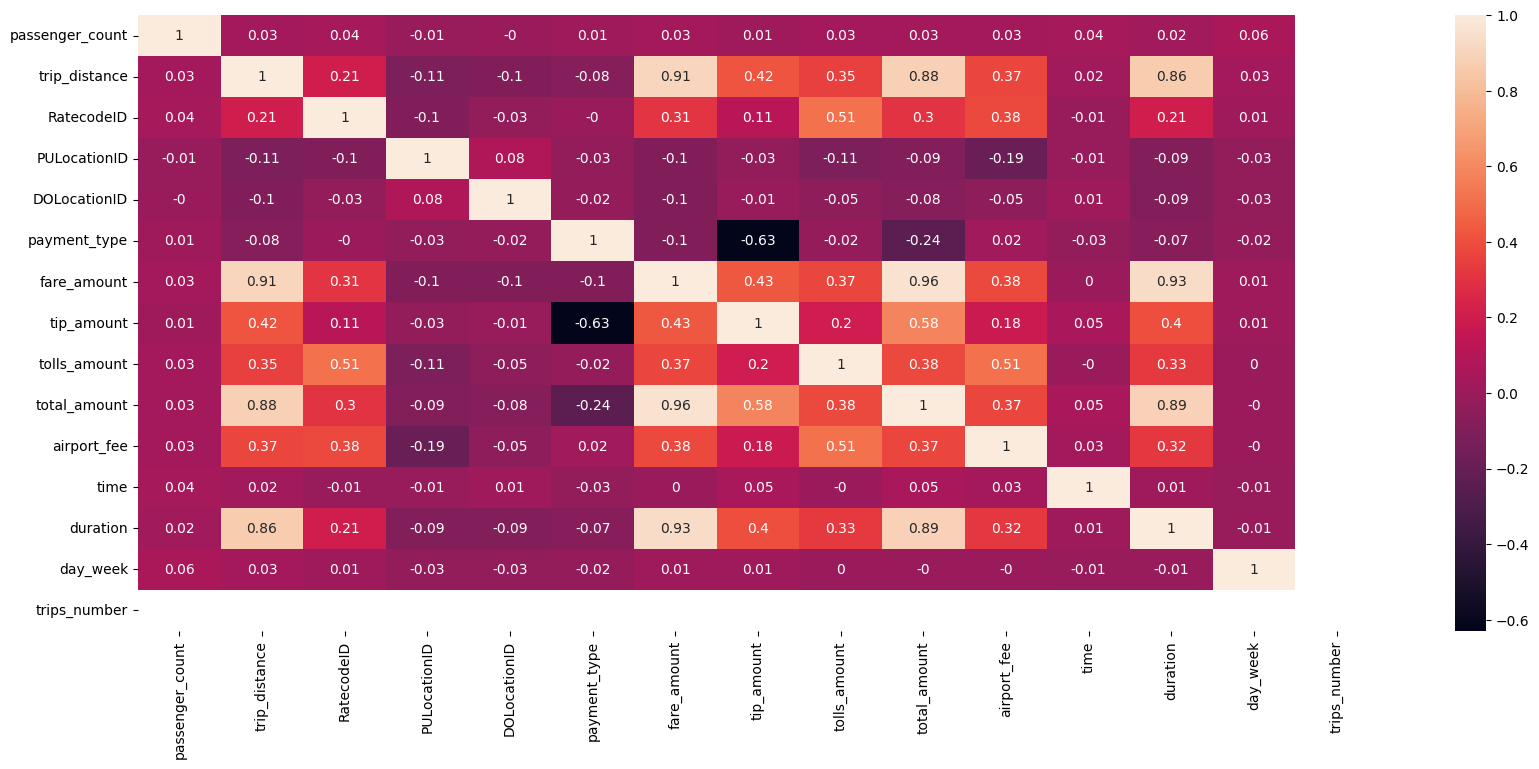

In [73]:
correlation_matrix = df.corr(method = 'spearman').round(2)
fig,axes = plt.subplots(1,1,figsize=(20,8))
sns.heatmap(data=correlation_matrix, annot=True,ax=axes);

In [111]:
(trips_number_max, trips_number_min)=calculate_maxes(df,'trips_number')
(total_max, total_min)=calculate_maxes(df,'total_amount')

In [109]:
lonmin, latmin, lonmax, latmax = geo_map.total_bounds

Text(0.5, 1.0, 'Heatmap of payments')

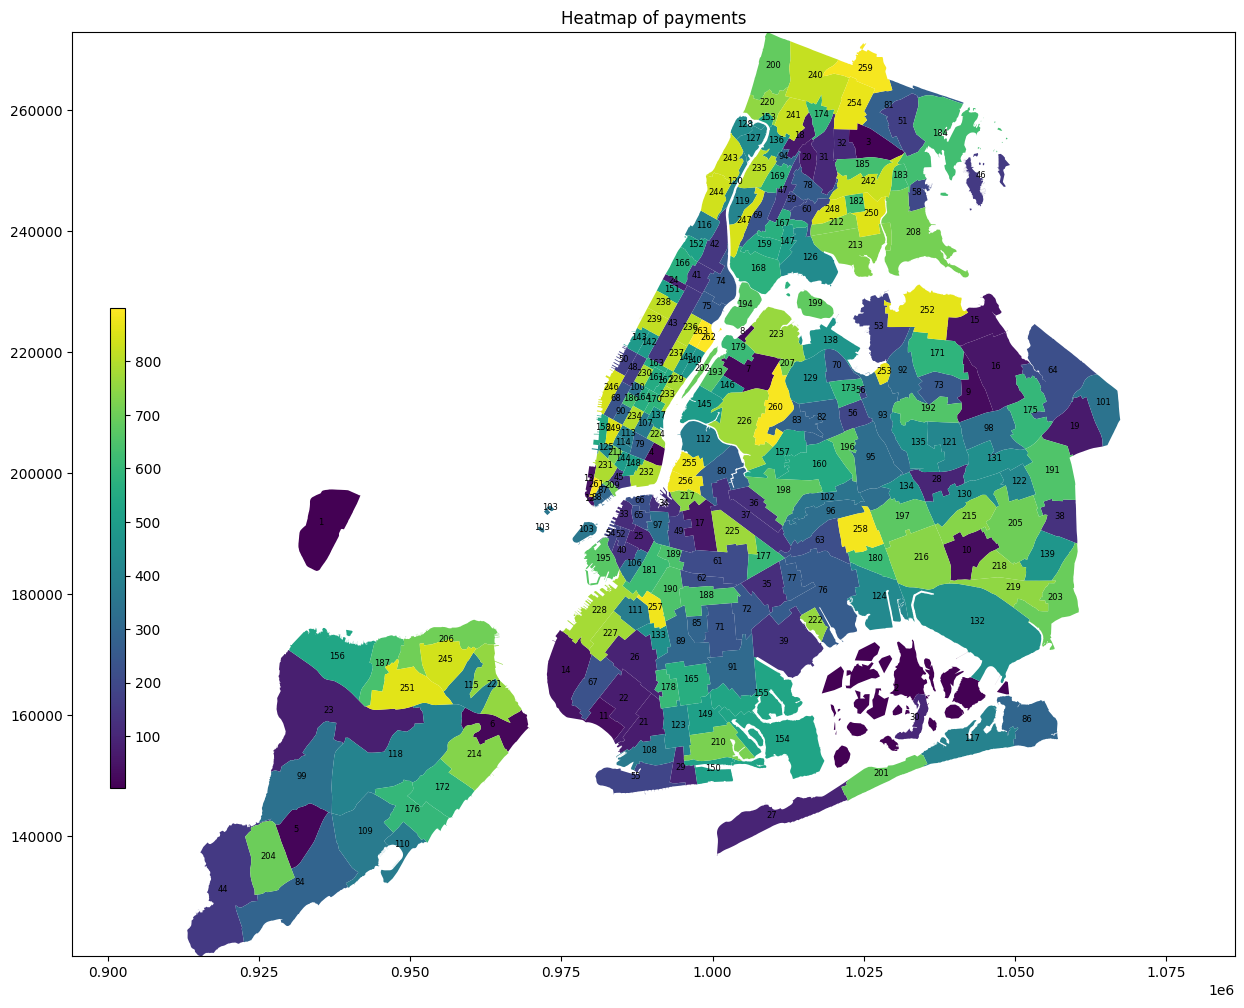

In [117]:
cmap = 'viridis'
fig, ax = plt.subplots(1, figsize=(15, 12))
ax = geo_map.plot(ax=ax,cmap = cmap, figsize=(15,12))
#ax = geo_map[~selection].plot(ax=ax,color = 'gray', figsize=(15,10))
ax.axis("equal")
ax.axis([lonmin, lonmax, latmin, latmax])

for x, y, label in zip(geo_map.centroid.x, geo_map.centroid.y, geo_map.LocationID):
    ax.annotate(label, xy=(x, y), xytext=(-5, 0), textcoords="offset points", color = 'black', fontsize = 6)
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=total_min, vmax=total_max), cmap = cmap)
cbaxes = fig.add_axes([0.15, 0.25, 0.01, 0.4])
cbar = fig.colorbar(sm, cax=cbaxes)
ax.set_title('Heatmap of payments') 

Text(0.5, 1.0, 'Heatmap of most recurrent zones')

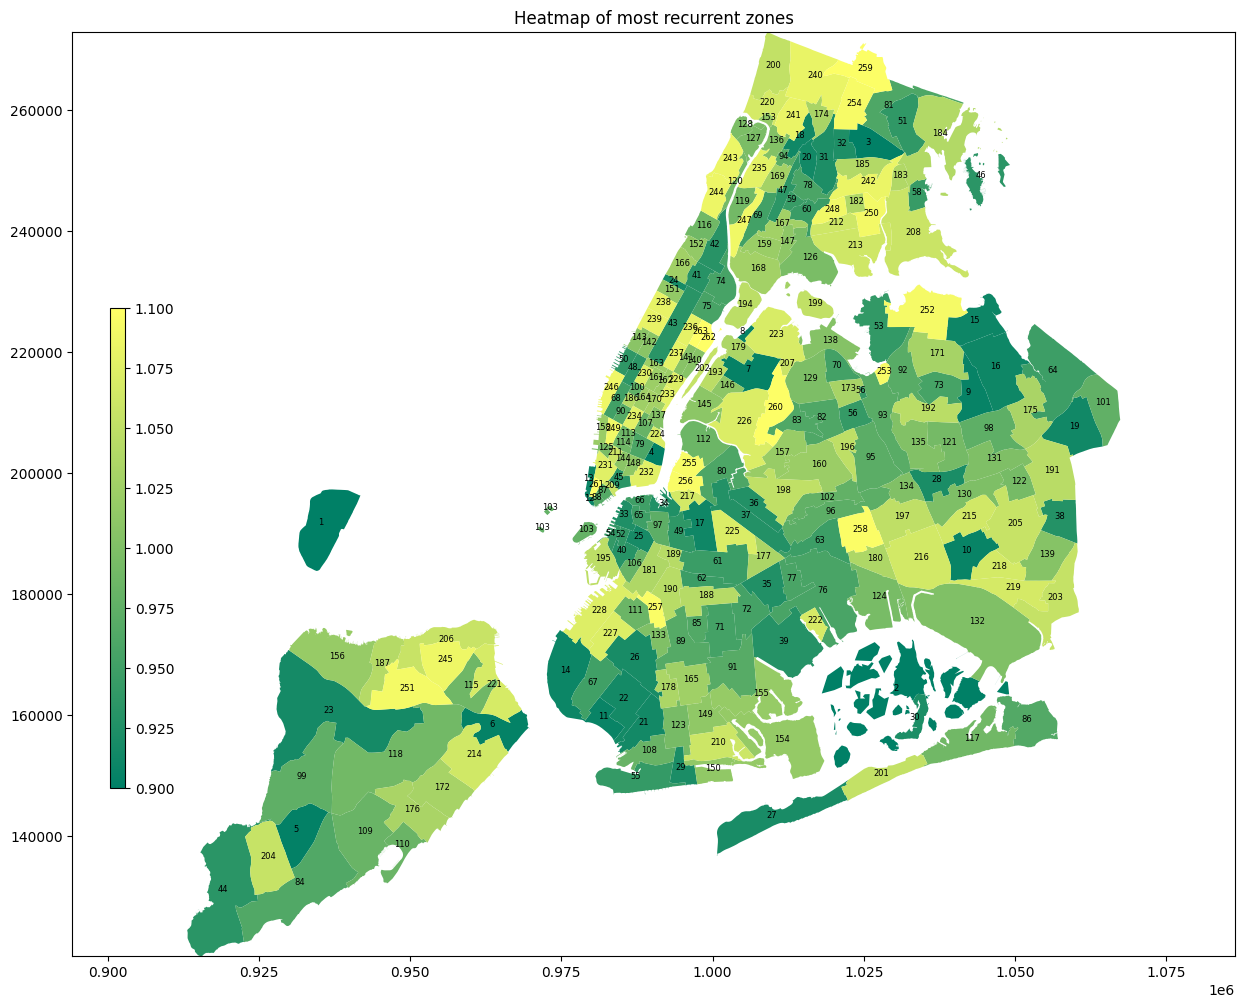

In [119]:
cmap = 'summer'
fig, ax = plt.subplots(1, figsize=(15, 12))
ax = geo_map.plot(ax=ax, figsize=(15,12), cmap=cmap, scheme='quantiles')
#ax = geo_map.plot(ax=ax,color = 'gray', figsize=(15,10))
ax.axis("equal")
ax.axis([lonmin, lonmax, latmin, latmax])

for x, y, label in zip(geo_map.centroid.x, geo_map.centroid.y, geo_map.LocationID):
    ax.annotate(label, xy=(x, y), xytext=(-5, 0), textcoords="offset points", color = 'black', fontsize = 6)
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=trips_number_min, vmax=trips_number_max), cmap = cmap)
cbaxes = fig.add_axes([0.15, 0.25, 0.01, 0.4])
cbar = fig.colorbar(sm, cax=cbaxes)
ax.set_title('Heatmap of most recurrent zones') 

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5341053 entries, 0 to 5440400
Data columns (total 21 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   tpep_pickup_datetime   datetime64[ns]
 1   tpep_dropoff_datetime  datetime64[ns]
 2   passenger_count        float64       
 3   trip_distance          float64       
 4   RatecodeID             float64       
 5   PULocationID           int64         
 6   DOLocationID           int64         
 7   payment_type           int64         
 8   fare_amount            float64       
 9   tip_amount             float64       
 10  tolls_amount           float64       
 11  total_amount           float64       
 12  airport_fee            float64       
 13  date                   datetime64[ns]
 14  time                   int64         
 15  weekday                object        
 16  duration               float64       
 17  day_of_year            object        
 18  day_week              

### Variables de Salida
| Nombre campo | Tipo de dato | Tipo | Significado
|-----------|-----------|-----------|-----------|
|total_amount          | float64    | Numerica| Monto total


### ¿Estan balanceadas las clases?
R/ Si

## 3. Limpieza y preparación de datos / ingeniería de features 

In [77]:
# remove invalid df
# passenger == 0
df = df[(df['passenger_count'] > 0) & (df['passenger_count'] < 7)]

# trip_distance <= 0
df = df[(df['trip_distance'] > 0) & (df['trip_distance'] <= 100)]

# exclude duration longer than 180 mins
df = df[(df['duration'] > 0) & (df['duration'] <= 180)]

# payment method other than cash and credit card
df = df[(df['payment_type'] != 3) & (df['payment_type'] != 4) & (df['payment_type'] != 5) & (df['payment_type'] != 6)]

# exclude instances with fare amount less than 2.5
df = df[(df['fare_amount'] >= 2.5) & (df['fare_amount'] <= 250)]

# PU and DO location id not within NYC taxi zone
df = df[(df['PULocationID'] >= 1) & (df['PULocationID'] <= 263) & (df['DOLocationID'] >= 1) & (df['DOLocationID'] <= 263)]

### Datos faltantes. Indicar cantidad de observaciones y valores faltantes para cada variable. 

In [78]:
df.isna().sum()

tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
tip_amount               0
tolls_amount             0
total_amount             0
airport_fee              0
date                     0
time                     0
weekday                  0
duration                 0
day_of_year              0
day_week                 0
day_type                 0
trips_number             0
dtype: int64

¿Qué supuestos puede realizar acerca de los datos faltantes? ¿Qué técnicas de imputación 
recomendaría? Ensayar distintas técnicas y analizar los resultados. 

### En función del estudio inicial de las variables que se hizo en la sección anterior, elegir una técnica de codificación para cada variable. Cuando lo considere apropiado, ensayar distintas técnicas y comparar los resultados, teniendo en cuenta el tipo de clasificador a utilizar. Nota: para tipos de  datos compuestos o estructurados, considerar la obtención de variables de tipo numérico/categórico.

¿Qué puede decir acerca de las relaciones entre las variables de entrada?
|

Antes de entrenar un modelo de aprendizaje automático, ¿Podría identificar las variables de 
entrada de mayor importancia? Considerar por lo menos dos técnicas para cada variable. Explique 
brevemente los métodos utilizados